In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

import numpy as np
#from ipynb.fs.full.AppProcessing import *
from itertools import zip_longest
import itertools as itertools

# app produces the package ID as part of the csv 

In [16]:
    
def prepareCsvForPkgId(input_file, returnjustfile = False):
    """
    Input:
        file (string): Is a csv produced by the app after 11.09.2020 containing info on the package ID. 
        returnjustfile (boolean = False): If true, only the file and not the list with Marc's ids, the filename and  the evenly index as list is returned
    Returns:
        file (dataframe): A kind of cleaned dataframe with an evenly space timestamp as index 
        ids (list): A list with the package ids as ints
        filename (string): The name of the experiment (if the name given from the app, including the timestamp) was used)
        index_evenly (array): The evenly spaced index as a list
    """
    file = pd.read_csv(input_file)
    file = file.iloc[1:]
    file.columns = file.iloc[0]

    file = file[1:].apply(pd.to_numeric, errors='ignore')

    # to evenly set the timestamps 
    length = len(file.index) # length of dataframe
    stop = length*4 # stop point 
    index_evenly = np.linspace(0, stop, num = length, endpoint = False) # to adapt timestamp  
    file.loc[:,"Time"] = index_evenly #set the time as index, relevant for later plotting

    ids= file.index.tolist() # these are all the package ids (as strings because, yes pandas of course we want that as strings, strings are soooo useful..Not)
    ids = [int(one_id) for one_id in ids] # now they are ints
    #print(ids)

    file.set_index('Time', inplace=True)
    # 
    filename = input_file[0:6]+input_file[20:-4]
    if returnjustfile:
        return file
    else:
        return file, ids, filename, index_evenly # no idea why, but the name of the index still includes "Pkg ID", the id not actually the index. Time is .. 



def grouper(iterable, n, fillvalue=None): # copied from StackOverflow
    '''
    Mostly Copied from StackOverflow. Takes a list and devided it into chunks of length n.
    Returns:
        toReturn: A list containing lists of length n
    '''
    args = [iter(iterable)] * n
    toReturn = list(zip_longest(*args, fillvalue=fillvalue)) # includes now the data types I want to work with (namely list of lists)
    toReturn = [list(oneChunk) for oneChunk in toReturn] # because one cannot turn tuples into sets. 
    return toReturn

The plan is to devide the list of Package Ids into chunks of 16. In a best case scenario, each chunk should contain all 16 values, if not, some Id was dropped. Find out how many chunks are incomplete. This approach is not perfect as extracting the exact info which id/how many pkgs/where the id is missing is not given but plotting the general area of a missed package should suffice. We'll see 

In [103]:

result_dict = {"Name": [], "Total": [], "Complete": [], "Ratio":[]} # to later save the results
result_df = pd.DataFrame(data=result_dict)

def evalCompleteness(IdChunkList, filename, perfectSet =  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}):
    '''
    Checks whether the individual chunks contain all package ids and are hence a complete set where nothing was dropped.
    Prints out a summary and saves the results in a dataframe (result_df)
    Input:
        chunklist(list of list): The list created by grouper
        filename (string): The name of the experiment, as produced by prepareCsvForPkgId() 
        perfectSet (set): The set of values that comprise all possible package ids, given by the app. 
                        Older Csv files contain the old naming ({1, 2, 3, 4, 5, 6, 7, -8, -7, -6, -5, -4, -3, -2, -1, 0}),
                        Newer ones, the default one ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15})
    '''
    ratio = []
    for chunk in IdChunkList:
        isSet = perfectSet.issubset(set(chunk))
        ratio.append(isSet)
    total = len(ratio)-1 # -1 because the last one usually is never complete
    complete = sum(ratio)
    ratio_abs = complete/total
    
    if ratio_abs < 0.1: 
        ratio = []
        print("Low results of ~{}~ indicate the old encoding scheme:".format(filename))
        perfectSet = {1, 2, 3, 4, 5, 6, 7, -8, -7, -6, -5, -4, -3, -2, -1, 0}
        for chunk in IdChunkList:
            isSet = perfectSet.issubset(set(chunk))
            ratio.append(isSet)
        total = len(ratio)-1 # -1 because the last one usually is never complete
        complete = sum(ratio)
        ratio_abs = complete/total
    print("Of {} chunks, {} contain all package Ids. The complete to incomplete ratio of the experiment ~{}~ is: {}.".format(total, complete, filename, ratio_abs))
    global result_df
    result_df = result_df.append({"Name": filename, "Total": total, "Complete": complete, "Ratio": ratio_abs}, ignore_index= True, verify_integrity=True)
    result_df.drop_duplicates(inplace=True) # clean that df
    
def analyseMissingAppPackages(filestring, perfectSet = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}):
    '''
    Function combines all steps of analysing missing packages that are dropped by the app  
    Input:
        filestring (string): The name of the file to be analysed, has to be in same directory
        perfectSet (set): The set of values that comprise all possible package ids, given by the app. 
                        Older Csv files contain the old naming ({1, 2, 3, 4, 5, 6, 7, -8, -7, -6, -5, -4, -3, -2, -1, 0}),
                        Newer ones, the default one ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15})
    '''
    
    file_df, ids_list, filename_string, index = prepareCsvForPkgId(filestring)
    try:
        print("\n Package Loss For", filename_string, "~ ",sum(file_df["Pkg Loss"].tolist()), " ~", "Total Amount of datapoints: ", len(file_df.index))
        print("Adapted (/3 due to BL characteristics) Percentage = ", ((sum(file_df["Pkg Loss"].tolist())/len(file_df.index))*100)/3)
    except KeyError:
        print(" ")
        #print("\n no Pkg Loss available for ", filename_string)
    #IdChunkList = grouper(ids_list, 16, 20) # 20 is just a random number bigger than the largest value in set (to fill the last set )
    #evalCompleteness(IdChunkList, filename_string, perfectSet)
    



In [104]:

extension = 'csv'
all_csv = glob.glob('*.{}'.format(extension))

print(all_csv) # to make sure we have all files 

for each_file in all_csv:
    if each_file != "01-09-2020_13-52-54_longTestApp.csv":
        analyseMissingAppPackages(each_file) 
result_df

['01-09-2020_13-52-54_longTestApp.csv', '14-10-2018_00-14-15_Exp1.1.csv', '14-10-2018_00-15-02_Exp1.2.csv', '16-09-2020_13-49-12_Exp2.1.csv', '16-09-2020_13-50-37_Exp2.2.csv', '16-09-2020_13-54-30_Exp3.1.csv', '16-09-2020_13-55-26_Exp3.2.csv', '16-09-2020_14-14-36_Exp4.2.csv', '16-09-2020_14-15-34_Exp4.1.csv', '21-09-2020_13-30-18_expno1.csv', '21-09-2020_13-32-09_exp2.csv', '21-09-2020_13-34-32_exp3.csv', '21-09-2020_13-35-13_exp4.csv', '21-09-2020_13-35-41_exp5.csv', '22-09-2020_14-45-40_expno1_tra8.csv', '22-09-2020_14-49-08_expno2_tra7.csv', '22-09-2020_15-45-20_expno3_tra8.csv', '22-09-2020_15-47-42_expno4_tra3.csv', '22-09-2020_16-38-12_exp5_8.csv', '22-09-2020_16-40-30_exp6_3.csv', '22-09-2020_17-05-04_exp7_3.csv', 'LongtermTestnRF.csv']
 
 
 
 
 
 
 
 

 Package Loss For 21-09-expno1 ~  0  ~ Total Amount of datapoints:  4759
Adapted (/3 due to BL characteristics) Percentage =  0.0

 Package Loss For 21-09-exp2 ~  0  ~ Total Amount of datapoints:  5246
Adapted (/3 due to BL char

,Name,Total,Complete,Ratio


In [38]:
def plotTraceApp(df, channelname = ["Ch-1","Ch-2","Ch-3","Ch-4","Ch-5","Ch-6"], fro = 0, to = 1000, sec=False, title = "Experiment", save = False, saveas = "Experiment"):
    """
    Plots the trace from individual Traumschreiber channels. 
    --------------
    Parameter:
    df: a cleaned up dataframe containing the app output
    channelname: the channelname to be displayed (default all, select subset if required) 
    fro (int): Starting point to plot the trace (in msec). If that msec does not correspond to a measurement, the closest one is used 
    to (int): End of the plot in msec. If that msec does not correspond to a measurement, the closest one is used instead.
    sec (boolean): If index is in seconds (specified in tidyTSAppOutput), the axis label is changed 
    title: Title of the plot
    save (boolean): True if plot shall be saved (in working directory) as png
    saveas (string): Name of the saved file
    """
    
    try: #find the nearest timestamp (only possible when index is unique)
        start = df.index.get_loc(fro, method = "nearest")
        stop = df.index.get_loc(to, method = "nearest")
        
    except: #if the data is not evenly spaced, there might be dublicated timestamps. Hack-around required
        # assuming the start/end point is given in msec (specified in function description). 
        # In average there should be a new measurement every 4 msec (sampling rate 250 Hz).
        # We calculate the indices that roughly correspond to the desired starting and stopping msecs instead
        samplingInterval = 4 
        start = int(fro/samplingInterval)
        stop = int(to/samplingInterval) 
    toPlot = df.iloc[start:stop] # cut only relevant part of dataframe for plotting
    
    #to do: count # channels to be plotted and automatically adapt plot size
    
    toPlot.plot(y = channelname, grid = True, title = title, sharex = False, marker='o', figsize = (30,6), subplots = True) #removed figsize

    if sec:
        plt.xlabel('Seconds')
    else:
        plt.xlabel("msec")
    plt.ylabel("mVolt")
     
    if save:    
        plt.savefig(saveas+'.png') # saves as .png at the moment as was better for displaying/discussing in slack
    plt.show()

Experiment 4 was condcuted with Marc's, the newer version of the app has a differnt pkg id naming system (signed vs unsigned). Weirdly, some packages where not complete. 

In [32]:
def differenceToNextMeasurement(dataframe, title, cut = False, save = False):
    """
    Requires a cleaned up (icluding pkg id) version of an dataframe. Plots only Channel 1 at the moment
    Input:
        dataframe (dataframe): A cleaned up dataframe
        title (string): The title for the plot as well as the saved image (if aplicable)
        cut (Boolean, default False): Whether the plot shall be cut at 3.7 to give a better insight into the important pattern of the difference
    """
    dataframe = dataframe.drop(["Ch-2","Ch-3","Ch-4","Ch-5","Ch-6","Ch-7","Ch-8"], axis=1).dropna(axis=1) 
    
    if cut:
        print("cutting")
        diff_cut = dataframe.diff(axis=0).abs()
        #print(diff)
        diff_cut = diff_cut[(diff_cut <3.7).any(1)]
        #print(diff)
        #print(app.index.tolist())
        #print()
        axis = diff_cut.index.tolist()
        yaxis = diff_cut["Ch-1"].abs().tolist()
        plt.scatter(x = axis, y = yaxis)
        plt.grid()
        plt.rcParams["figure.figsize"] = (10,7)
        plt.xlabel("Time in msecs")
        plt.ylabel("Absolut difference to next measurement")
        plt.title(title+" Difference to neighbouring measurement, only displaying differences <3.7")
        if save:
            plt.savefig(title+"DifferencesWithThreshold.png")
        plt.show()
        
    else:
        print("Not cutting")
        diff = dataframe.diff(axis=0)
        axis = dataframe.index.tolist()
        yaxis = diff["Ch-1"].abs().tolist()
        plt.scatter(x = axis, y = yaxis)
        plt.grid()
        plt.rcParams["figure.figsize"] = (10,7)
        plt.xlabel("Time in msecs")
        plt.ylabel("Absolut difference to next measurement")
        plt.title(title+" Difference to neighbouring measurement")
        #plt.savefig(title+"Differences.png")
        if save:
            plt.savefig(title+"DifferencesWithThreshold.png")
        plt.show()


In [45]:
# dif_plot = prepareCsvForPkgId("21-09-2020_13-32-09_exp2.csv", returnjustfile = True).drop(["Ch-2","Ch-3","Ch-4","Ch-5","Ch-6","Ch-7","Ch-8","Pkg Loss"], axis=1).dropna(axis=1) 

# dif_plot["Difference"] =dif_plot.diff(axis=0).abs()
# dif_df = dif_plot.drop(["Ch-1"], axis =1)
# #dif_df

# # print(dif_plot[(dif_plot > 3.7).any("Difference")])
      
# bigger = dif_df[(dif_df >3.7).any(1)]
# bigger
# biggest_differences_df = bigger["Difference"].nlargest(n=100)
# bd_list = biggest_differences_df.index.tolist() #list of the timestamp when the biggest difference occur
# sortedList = sorted(bd_list)

        
def grouper2(iterable, closeMeansWithin = 50): # from stackoverflow
    """
    Helper function to evaluate if drops and jumps are in the same area
    """
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= closeMeansWithin: # if the values are in a range of 50, they are in the same cycle (approximately)
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group


# DictOfJumps = dict(enumerate(grouper2(sortedList), 1))
# print(len(DictOfJumps))   
# for key, value in DictOfJumps.items():
    
#     first_jump = value[0]
#     first_jump_pos = int(first_jump/4)
#     last_jump = value[-1]
#     last_jump_pos = int(last_jump/4)
#     plot_from = first_jump_pos -45
#     plot_to = last_jump_pos +45
#     print("from", plot_from, "to", plot_to)
    
    #dif_plot.iloc[plot_from:plot_to].plot(marker ='o', title = "There are {} abnormalties between {} and {}".format(len(value),first_jump, last_jump))
    
#index_of_bigger = bigger.index
#print(index_of_bigger)
#print(bd_list)
# for time in bd_list:
#     pos = int(time/4)
#     #print(pos)
#     start = pos-75
#     end = pos+75
    #dif_plot.iloc[start:end].plot(marker ='o')
    #plt.savefig("BigJumpAt_"+str(time)+'_msec.png')


0
Pkg ID   Pkg Loss       Ch-1
Time                        
0.0             0 -12.862872
4.0             0 -15.521032
8.0             0 -17.942879
12.0            0 -20.084604
16.0            0 -21.920284
20.0            0 -23.423695
24.0            0 -24.559967
28.0            0 -25.320463
32.0            0 -25.692070
36.0            0 -25.663760
40.0            0 -25.236130
44.0            0 -24.415438
48.0            0 -23.224333
52.0            0 -21.674732
56.0            0 -19.788094
60.0            0 -17.598091
64.0            0 -15.142572
68.0            0 -12.456996
72.0            0  -9.583084
76.0            0  -6.567026
80.0            0  -3.456502
84.0            0  -0.308728
88.0            0   2.840238
92.0            0   5.943014
96.0            0   8.942980
100.0           0  11.798714
104.0           0  14.452702
108.0           0  16.876635
112.0           0  19.027300
116.0           0  20.862682
...           ...        ...
20864.0         0   3.185918
20868.0     

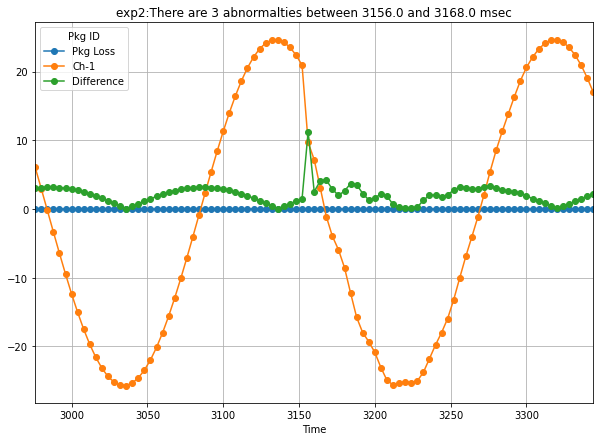

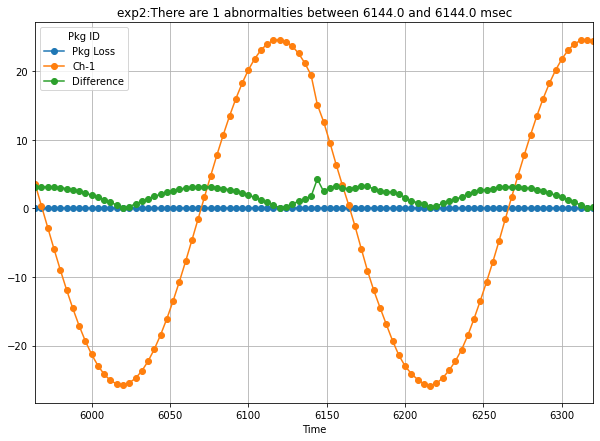

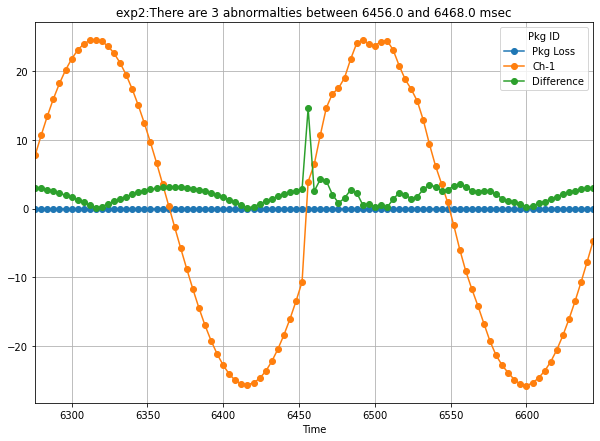

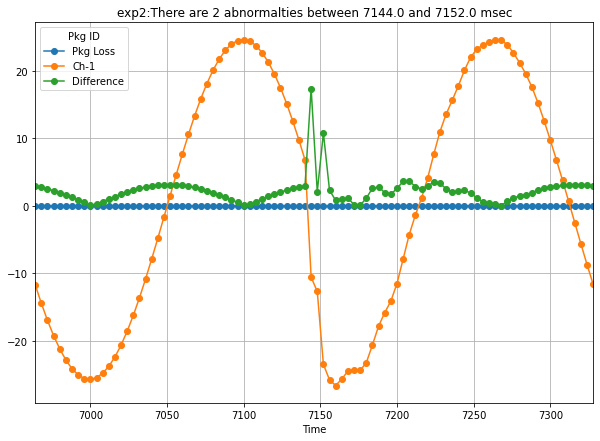

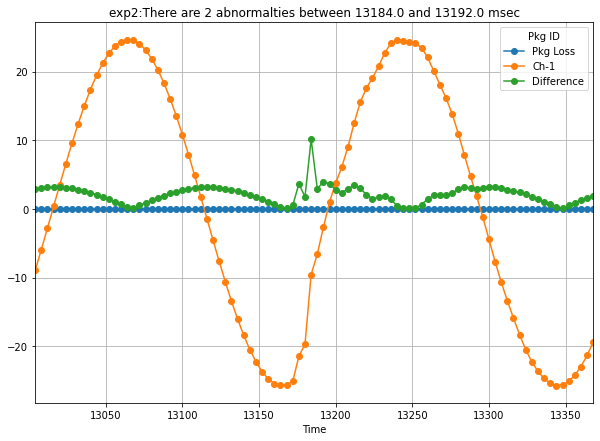

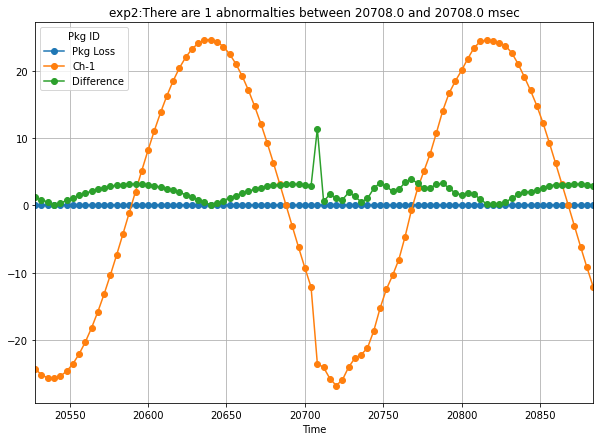

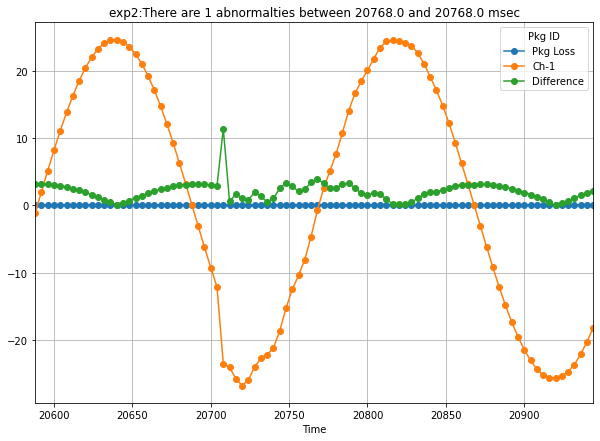

In [149]:
def PlotJumps(justTheFileName, save = False):
    """
    Plots the parts of the Signal where the difference to the next measurement is larger than 3.7, indicating an abnormalty
    Input:
        justTheFileName (string): The name of the csv to be processed. has to be in same folder. 
    """
    name = justTheFileName[20:-4]
    #dif_plot = prepareCsvForPkgId(justTheFile, returnjustfile = True).drop(["Ch-2","Ch-3","Ch-4","Ch-5","Ch-6","Ch-7","Ch-8"], axis=1).dropna(axis=1) 
    withLoss = prepareCsvForPkgId(justTheFileName, returnjustfile = True).drop(["Ch-2","Ch-3","Ch-4","Ch-5","Ch-6","Ch-7","Ch-8"], axis=1).dropna(axis=1) 
    #dif_plot = prepareCsvForPkgId(justTheFileName, returnjustfile = True).drop(["Ch-2","Ch-3","Ch-4","Ch-5","Ch-6","Ch-7","Ch-8", "Pkg Loss"], axis=1).dropna(axis=1) 
    print(withLoss)
    # might have to include except for older versions that don't have the Pkg Loss yet
    dif_plot = withLoss.drop(["Pkg Loss"], axis=1) 
    print(dif_plot)
    dif_plot["Difference"] =dif_plot.diff(axis=0).abs()
    dif_df = dif_plot.drop(["Ch-1"], axis =1)


    bigger = dif_df[(dif_df >3.7).any(1)]
    bigger
    biggest_differences_df = bigger["Difference"].nlargest(n=100)
    bd_list = biggest_differences_df.index.tolist() #list of the timestamp when the biggest difference occur
    sortedList = sorted(bd_list)


    DictOfJumps = dict(enumerate(grouper2(sortedList), 1))
    ratio = round( len(bigger.index)/len(dif_plot.index),3)
    print("For ~{}~ and its {} measured data points, {} are abnormal. The ratio is {}. The jumps occur in {} parts of the signal".format(justTheFileName,len(dif_plot.index),len(bigger.index),ratio,len(DictOfJumps)))
    #test = prepareCsvForPkgId(justTheFileName, returnjustfile = True)
    #print(test.index)
    #test = pd.concat([dif_plot, justTheFileName["Pkg Loss"]])
    #print(justTheFileName.index)
    combined = pd.concat([withLoss, dif_df], axis=1)
    
    for key, value in DictOfJumps.items():

        first_jump = value[0]
        first_jump_pos = int(first_jump/4)
        last_jump = value[-1]
        last_jump_pos = int(last_jump/4)
        plot_from = first_jump_pos -45
        if plot_from < 0:
            plot_from = 0
        plot_to = last_jump_pos +45
        if plot_to > len(dif_plot.index):
            plot_to = len(dif_plot.index)
        #print("from", plot_from, "to", plot_to)
        combined.iloc[plot_from:plot_to].plot(marker ='o', title = "{}:There are {} abnormalties between {} and {} msec".format(name,len(value),first_jump, last_jump), grid=True)
        plt.savefig("JumpsAndPackageLoss_{}-{}-{}.png".format(name,first_jump, last_jump))
        #         if save:
#             plt.savefig(name+"_"+str(first_jump)+"_to_"+str(last_jump)+'_msec.png')
        
#PlotJumps("21-09-2020_13-35-41_exp5.csv",save=True)
df2 = prepareCsvForPkgId("21-09-2020_13-32-09_exp2.csv", returnjustfile = True)
print(sum(df2["Pkg Loss"]))
#differenceToNextMeasurement(df2, "Exp2_21.09.2020")#, cut = True)
PlotJumps("21-09-2020_13-32-09_exp2.csv", save=True)

In [34]:
#print(all_csv)
# for each_file in all_csv:
#     file_df, ids_list, filename_string = prepareCsvForPkgId(each_file)
#     #differenceToNextMeasurement(file_df, filename_string)
#     differenceToNextMeasurement(file_df, filename_string, cut = True)

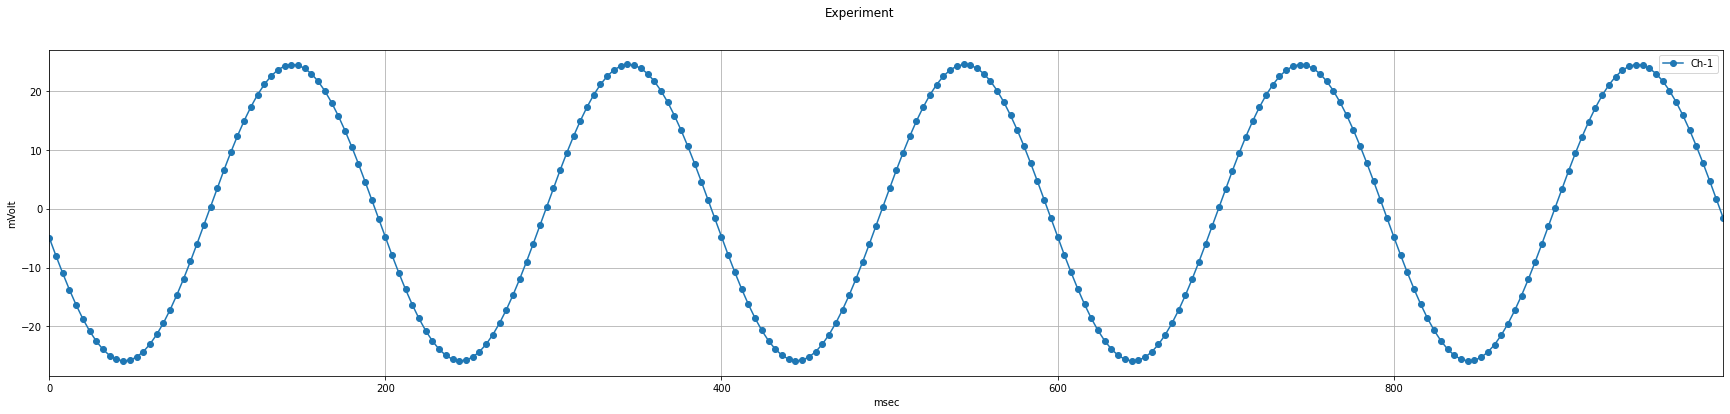

In [39]:
# Get x values of the sine wave

# file = prepareCsvForPkgId("14-10-2018_00-14-15_Exp1.1.csv")[0]
# time = prepareCsvForPkgId("14-10-2018_00-14-15_Exp1.1.csv")[3]

# plotTraceApp(file, channelname = ["Ch-1"])

# file = file.iloc[0:1000]
# time_short = time[0:1000]



In [35]:
def read_clean_nRF(file, start_with_0 = False):
    df = pd.read_csv(file)
    df.drop(labels = "time", axis = "columns", inplace = True, errors= 'ignore')

    df.rename(columns={'Unnamed: 1':'Ch-1', 'Unnamed: 2':'Channel 2', 'Unnamed: 3':'Channel 3', 'Unnamed: 4':'Channel 4', 'Unnamed: 5':'Channel 5', 'Unnamed: 6':'Channel 6'}, inplace=True )
    
    df = df.drop(["Channel 2","Channel 3","Channel 4","Channel 5","Channel 6","Unnamed: 7"], axis=1).dropna(axis=1)
#print(nRF)
    #df = df.divide(2980)
    df = df.divide(3300)
    return df

nrf = read_clean_nRF("LongtermTestnRF.csv")


inp= 0
closeToZero = nrf.iloc[(nrf['Ch-1']-inp).abs().argsort()[:10]]
closest = closeToZero.index.tolist()[0]
perfect = nrf.loc[closest:,:]


length = len(perfect.index) # length of dataframe
stop = length*4 # stop point 
index_evenly = np.linspace(0, stop, num = length, endpoint = False)
perfect.index = index_evenly # vhange index to start at 0 for better comparability 
perfect # starts upward, 



#perfect.iloc[0:500].plot(y = ["Ch-1"])

def FindRisingSineCloseToZero(df):
    """
    Cuts the daframe to make it start close to zero with a rising sine 
    """
    inp= 0
    closeToZero = df.iloc[(df['Ch-1']-inp).abs().argsort()[:200]]
    
    closeToZeroList = closeToZero.index.tolist()
    #closest = closeToZero.index.tolist()[0]
    #print(closeToZeroList)
   
    for i in closeToZeroList:
        perfect = df.loc[i:,:]
        #print(perfect.head())
        if perfect["Ch-1"].iloc[1] > 0:
            print("Found a rising one for ", perfect["Ch-1"].iloc[0])
            break
        else:
            print("Did not find a rising one for ", perfect["Ch-1"].iloc[0] )

    length = len(perfect.index) # length of dataframe
    stop = length*4 # stop point 
    index_evenly = np.linspace(0, stop, num = length, endpoint = False)
    perfect.index = index_evenly # vhange index to start at 0 for better comparability 
    return perfect # starts upward, 



Found a rising one for  0.00447
Found a rising one for  0.008343999999999999
Did not find a rising one for  -0.002682
Did not find a rising one for  0.008046
Found a rising one for  0.011323999999999999
Did not find a rising one for  0.000596
Found a rising one for  -0.006854000000000001


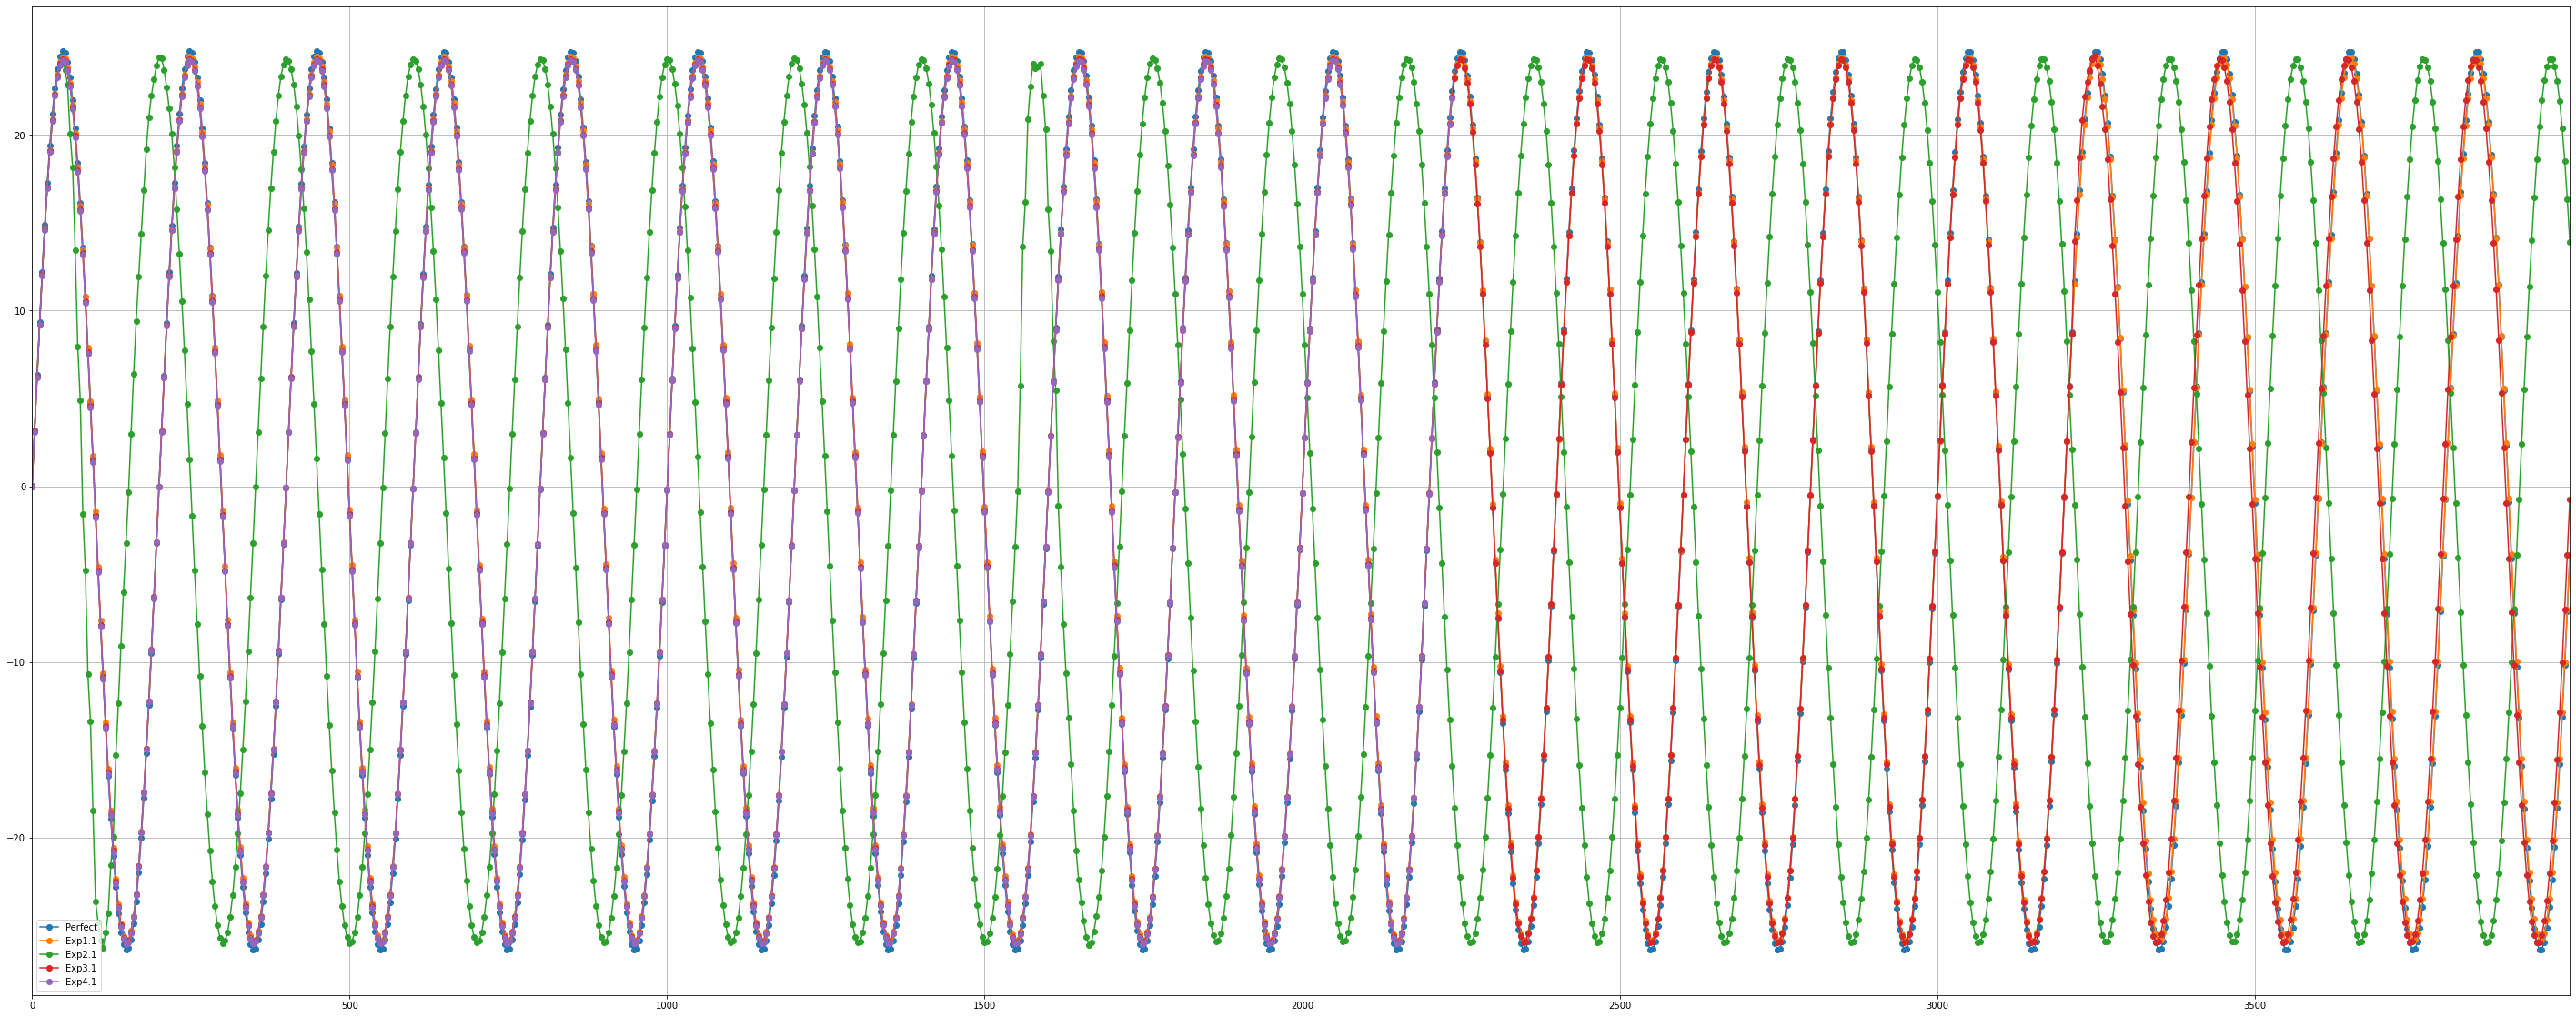

In [36]:
exp1 = FindRisingSineCloseToZero(prepareCsvForPkgId("14-10-2018_00-14-15_Exp1.1.csv", returnjustfile = True))
exp2 = FindRisingSineCloseToZero(prepareCsvForPkgId("16-09-2020_13-49-12_Exp2.1.csv", returnjustfile = True))
exp3 = FindRisingSineCloseToZero(prepareCsvForPkgId("16-09-2020_13-54-30_Exp3.1.csv", returnjustfile = True))

exp4 = FindRisingSineCloseToZero(prepareCsvForPkgId("16-09-2020_14-15-34_Exp4.1.csv", returnjustfile = True))


data = [perfect["Ch-1"], exp1["Ch-1"],exp2["Ch-1"],exp3["Ch-1"],exp4["Ch-1"]]
header = ["Perfect", "Exp1.1", "Exp2.1", "Exp3.1", "Exp4.1"]

combined = pd.concat(data, axis =1, keys =header)
combined

combined.iloc[0:1000].plot(grid = True, marker='o', figsize = (50,20))


In [15]:
# fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
# ax1.xcorr(combined["Perfect"].iloc[0:500], combined["Perfect"].iloc[0:500], usevlines=True, maxlags=50, normed=True, lw=2)
# ax1.grid(True)

# ax2.acorr(combined["Perfect"].iloc[0:500], usevlines=True, normed=True, maxlags=50, lw=2)
# ax2.grid(True)

# plt.show()

Now we're evaluating the two dropped packag ids 


In [16]:
#df = pd.read_csv()

file = pd.read_csv("21-09-2020_13-32-09_exp2.csv")
file = file.iloc[1:]
file.columns = file.iloc[0]

file = file[1:].apply(pd.to_numeric, errors='ignore')

# to evenly set the timestamps 
length = len(file.index) # length of dataframe
stop = length*4 # stop point 
index_evenly = np.linspace(0, stop, num = length, endpoint = False) # to adapt timestamp  
file.loc[:,"Time"] = index_evenly #set the time as index, relevant for later plotting
#print(index_evenly)
#print(file.index.tolist())
ids= file.index.tolist() # these are all the package ids (as strings because, yes pandas of course we want that as strings, strings are soooo useful..Not)
ids = [int(one_id) for one_id in ids] # now they are ints
#print(ids)

file.set_index('Time', inplace=True)
# 
#filename = input_file[20:-4]
losses = file["Pkg Loss"].tolist()
#print(sum(losses))
file

0


Pkg ID,Pkg Loss,Ch-1,Ch-2,Ch-3,Ch-4,Ch-5,Ch-6,Ch-7,Ch-8,nan,nan,nan,nan
Time,,,,,,,,,,,,,
0.0,0,-12.862872,-1229.1454,2.381318,761.56525,-764.35390,0.374586,NaN,NaN,NaN,NaN,NaN,NaN
4.0,0,-15.521032,-1226.3213,2.620910,745.79596,-749.01227,0.726822,NaN,NaN,NaN,NaN,NaN,NaN
8.0,0,-17.942879,-1224.0677,2.173612,880.48510,-882.95490,0.159728,NaN,NaN,NaN,NaN,NaN,NaN
12.0,0,-20.084604,-1221.8220,2.554158,677.53340,-680.67580,0.720564,NaN,NaN,NaN,NaN,NaN,NaN
16.0,0,-21.920284,-1219.9840,2.290428,869.60333,-872.33000,0.387400,NaN,NaN,NaN,NaN,NaN,NaN
20.0,0,-23.423695,-1218.5679,2.325294,762.60016,-765.35160,0.399916,NaN,NaN,NaN,NaN,NaN,NaN
24.0,0,-24.559967,-1217.2979,2.430786,744.16260,-747.19090,0.713114,NaN,NaN,NaN,NaN,NaN,NaN
28.0,0,-25.320463,-1216.6866,2.173314,877.22910,-879.70910,0.177608,NaN,NaN,NaN,NaN,NaN,NaN
32.0,0,-25.692070,-1216.2098,2.541642,679.43555,-682.56540,0.726822,NaN,NaN,NaN,NaN,NaN,NaN


0
0
Not cutting


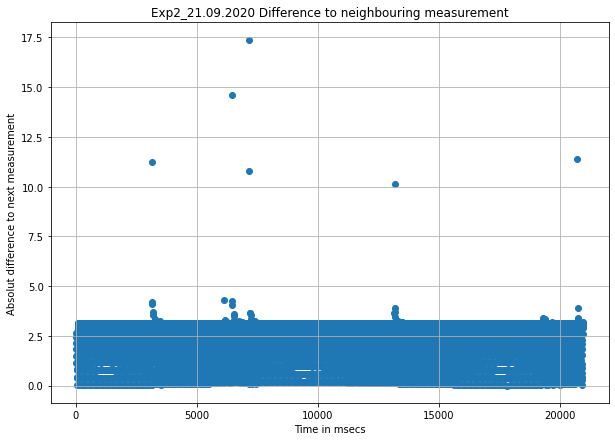

AttributeError: 'DataFrame' object has no attribute 'header'

In [135]:
# analyseMissingAppPackages("21-09-2020_13-32-09_exp2.csv")
# analyseMissingAppPackages("21-09-2020_13-34-32_exp3.csv")
# analyseMissingAppPackages("21-09-2020_13-35-13_exp4.csv")
# analyseMissingAppPackages("21-09-2020_13-35-41_exp5.csv")


df1 = prepareCsvForPkgId("21-09-2020_13-30-18_expno1.csv", returnjustfile = True)
print(sum(df1["Pkg Loss"]))
#differenceToNextMeasurement(df1, "Exp1_21.09.2020")#, cut = True)

#PlotJumps("21-09-2020_13-30-18_expno1.csv",save=True)

df2 = prepareCsvForPkgId("21-09-2020_13-32-09_exp2.csv", returnjustfile = True)
print(sum(df2["Pkg Loss"]))
differenceToNextMeasurement(df2, "Exp2_21.09.2020")#, cut = True)
PlotJumps("21-09-2020_13-32-09_exp2.csv",save=True)

df3 = prepareCsvForPkgId("21-09-2020_13-34-32_exp3.csv", returnjustfile = True)
print(sum(df3["Pkg Loss"]))

#differenceToNextMeasurement(df3, "Exp3_21.09.2020")#, cut = True)
#PlotJumps("21-09-2020_13-34-32_exp3.csv",save=True)

df4 = prepareCsvForPkgId("21-09-2020_13-35-13_exp4.csv", returnjustfile = True)
print(sum(df4["Pkg Loss"]))
#differenceToNextMeasurement(df4, "Exp4_21.09.2020")#, cut = True)
#PlotJumps("21-09-2020_13-35-13_exp4.csv",save=True)

df5 = prepareCsvForPkgId("21-09-2020_13-35-41_exp5.csv", returnjustfile = True)
print(sum(df5["Pkg Loss"]))
#differenceToNextMeasurement(df5, "Exp5_21.09.2020", cut = True)
#PlotJumps("21-09-2020_13-35-41_exp5.csv",save=True)

# df1_8 = prepareCsvForPkgId("22-09-2020_14-45-40_expno1_tra8.csv", returnjustfile = True)
# differenceToNextMeasurement(df1_8.iloc[0:3000], "Exp1_8_22.09.2020", cut = False)
# PlotJumps("22-09-2020_14-45-40_expno1_tra8.csv",save=True)

# df2_7 = prepareCsvForPkgId("22-09-2020_14-49-08_expno2_tra7.csv", returnjustfile = True)
# differenceToNextMeasurement(df2_7, "Exp2_7_22.09.2020", cut = True)
# PlotJumps("22-09-2020_14-49-08_expno2_tra7.csv",save=True)

# df3_8 = prepareCsvForPkgId("22-09-2020_15-45-20_expno3_tra8.csv", returnjustfile = True)
# differenceToNextMeasurement(df3_8, "Exp3_8_22.09.2020", cut = True)
# PlotJumps("22-09-2020_15-45-20_expno3_tra8.csv",save=True)
# df3_8["Ch-1"].iloc[0:200].plot()

# df4_3 = prepareCsvForPkgId("22-09-2020_15-47-42_expno4_tra3.csv", returnjustfile = True)

# differenceToNextMeasurement(df4_3, "Exp4_3_22.09.2020", cut = False)
# PlotJumps("22-09-2020_15-47-42_expno4_tra3.csv",save=True)



# df5_8 = prepareCsvForPkgId("22-09-2020_16-38-12_exp5_8.csv", returnjustfile = True)
# differenceToNextMeasurement(df5_8, "Exp5_8_22.09.2020", cut = False)
# PlotJumps("22-09-2020_16-38-12_exp5_8.csv",save=True)


#df6_3 = prepareCsvForPkgId("22-09-2020_16-40-30_exp6_3.csv", returnjustfile = True)
#differenceToNextMeasurement(df6_3, "Exp6_3_22.09.2020", cut = False)
#PlotJumps("22-09-2020_16-40-30_exp6_3.csv",save=True)
#analyseMissingAppPackages("22-09-2020_16-40-30_exp6_3.csv")
#differenceToNextMeasurement(df6_3, "Exp6_3_22.09.2020", cut = False)
#PlotJumps("22-09-2020_16-40-30_exp6_3.csv",save=True)

[0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 0, 5, 0, 0, 0, 10, 9, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 15, 8, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 5, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 5, 0, 0, 2, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 2, 0, 6, 0, 0, 1, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 15, 0, 0, 0, 9, 0, 0, 3, 0, 0, 2, 8, 8, 0, 0, 15, 0, 0, 0

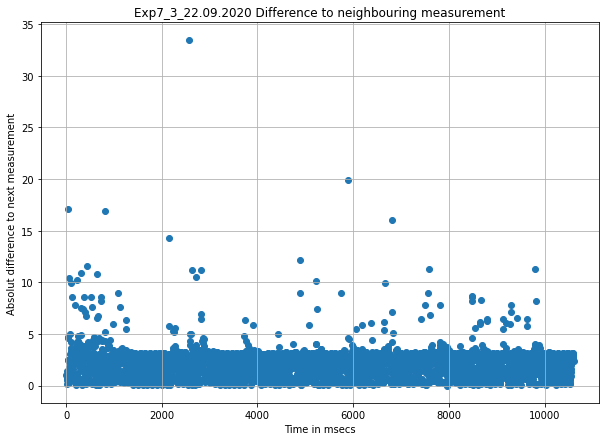

In [200]:
df7_3 = prepareCsvForPkgId("22-09-2020_17-05-04_exp7_3.csv", returnjustfile=True)
print(df7_3["Pkg Loss"].tolist())

analyseMissingAppPackages("22-09-2020_17-05-04_exp7_3.csv")
differenceToNextMeasurement(df7_3, "Exp7_3_22.09.2020", cut = False)
#PlotJumps("22-09-2020_17-05-04_exp7_3.csv",save=True)

1095


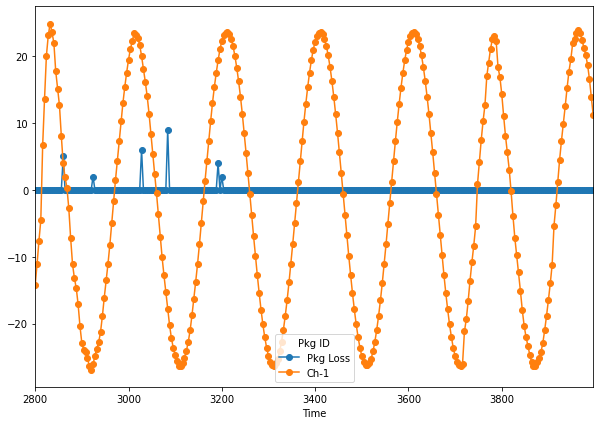

In [217]:
toPrint = df7_3.drop(["Ch-2","Ch-3","Ch-4","Ch-5","Ch-6","Ch-7","Ch-8"], axis=1).dropna(axis=1)
print(sum(toPrint["Pkg Loss"]))
toPrint.iloc[700:1000].plot(marker ='o')

For ~22-09-2020_17-05-04_exp7_3.csv~ and its 2653 measured data points, 178 are abnormal. The ratio is 0.067. In total 1095 (~ 365.0) packages are lost.
 The losses occur in 35 parts of the signal. 


C:\Users\lkrie\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\lkrie\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\lkrie\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

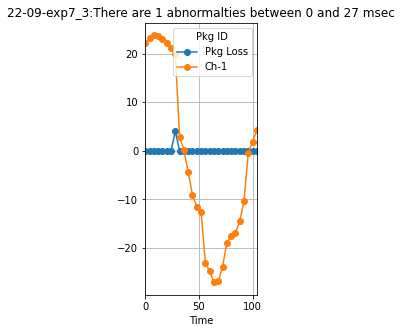

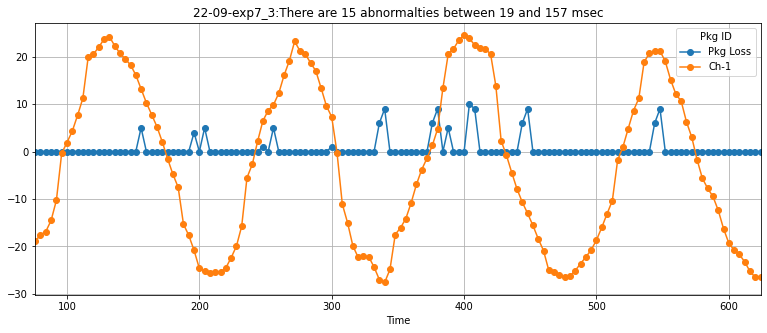

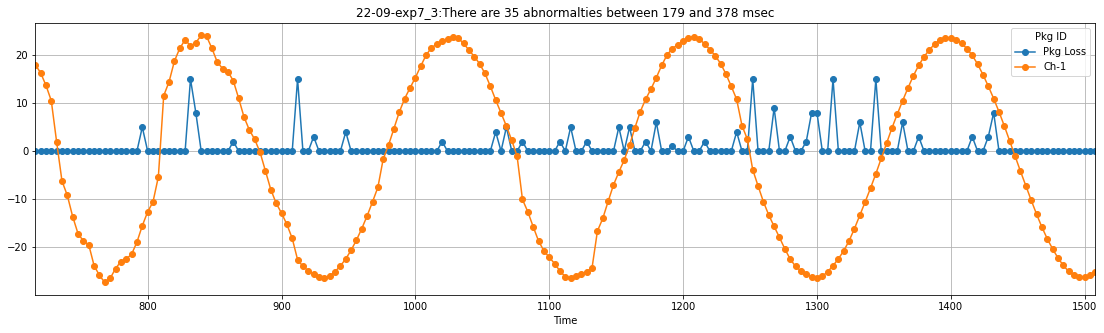

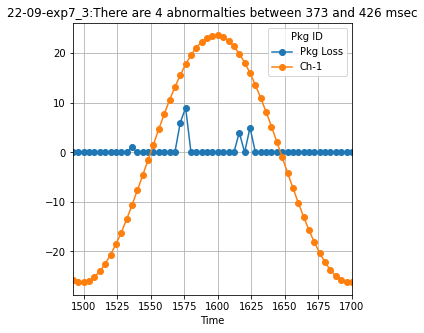

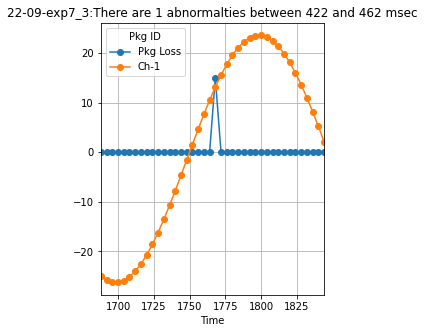

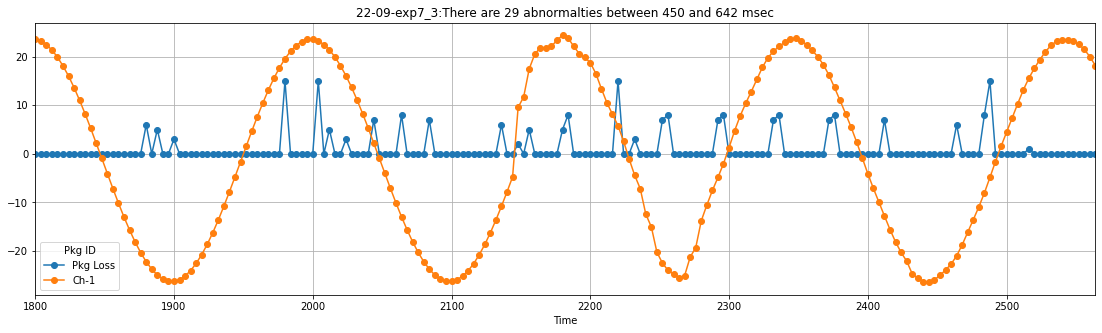

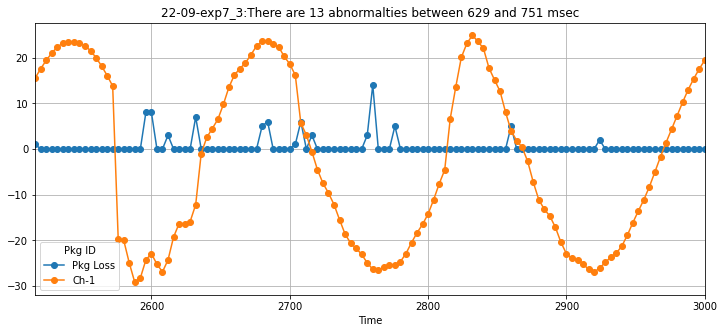

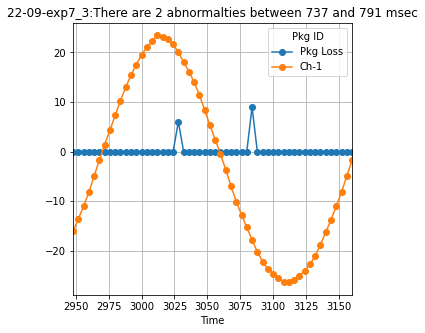

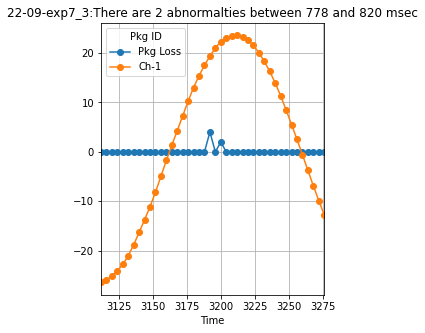

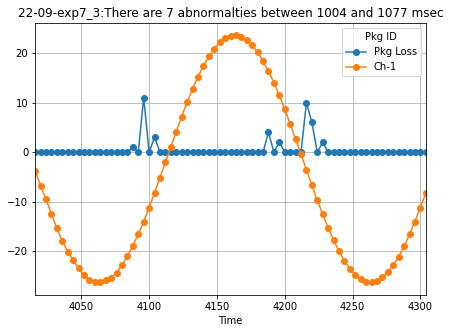

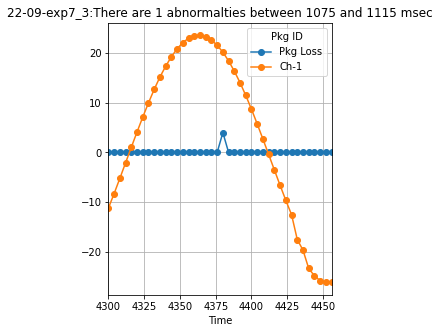

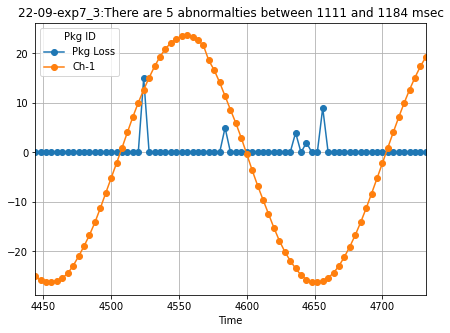

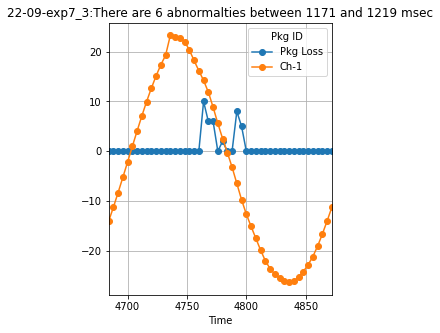

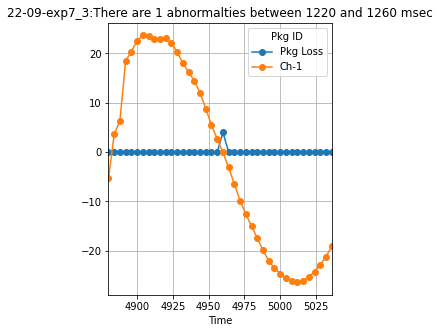

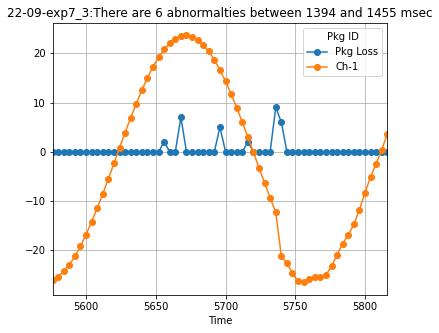

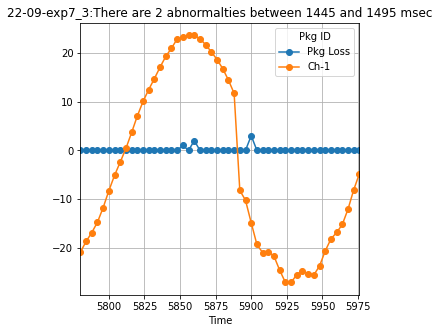

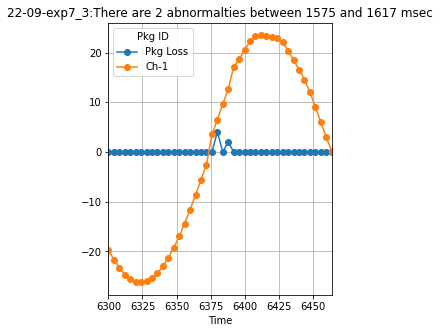

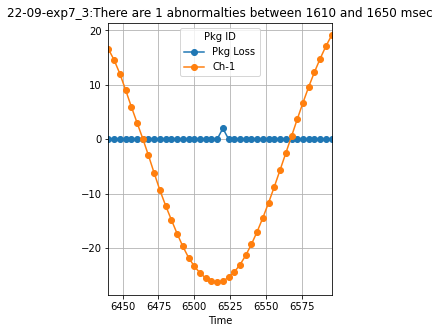

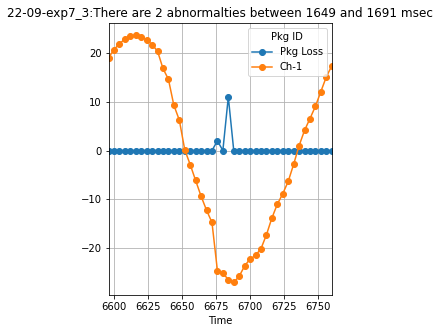

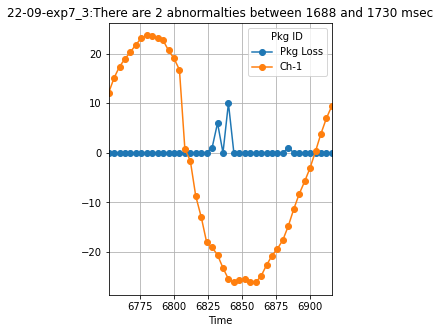

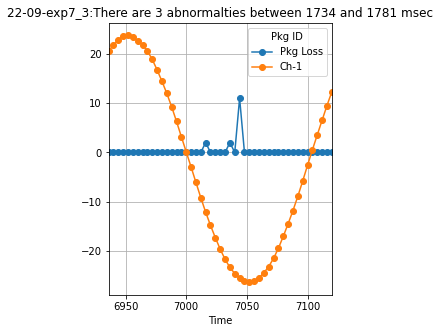

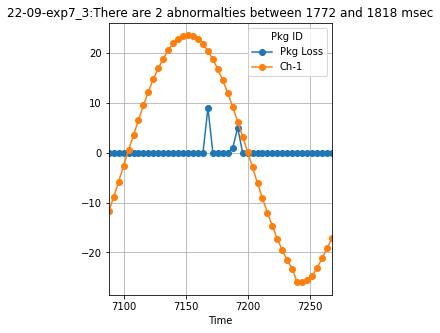

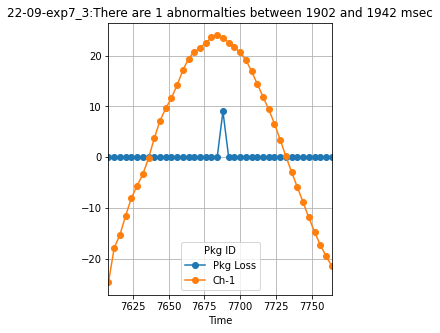

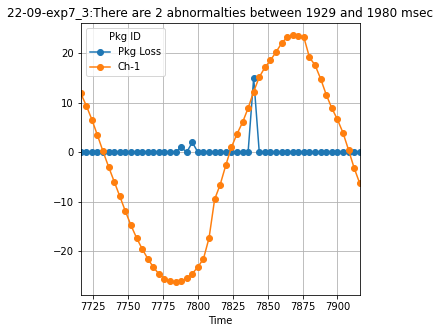

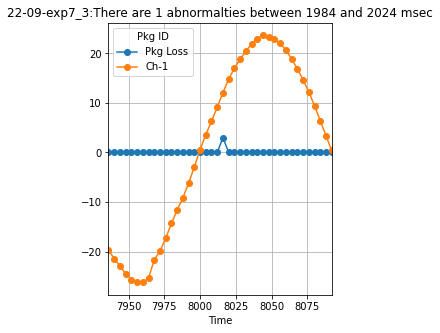

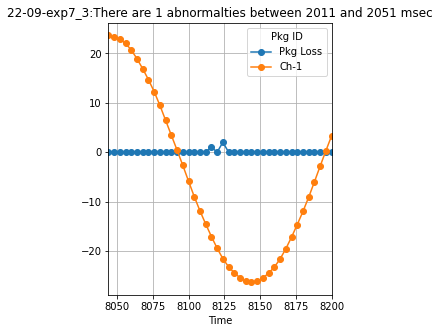

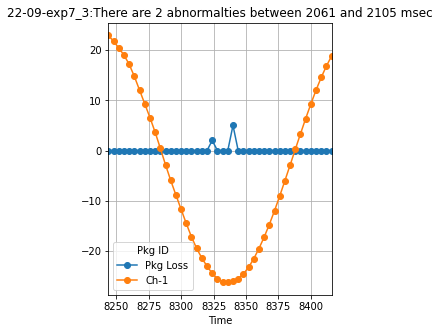

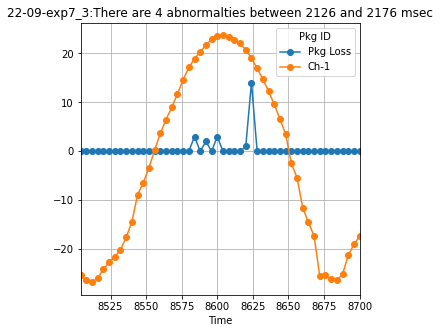

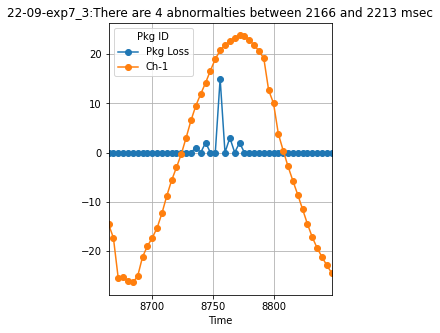

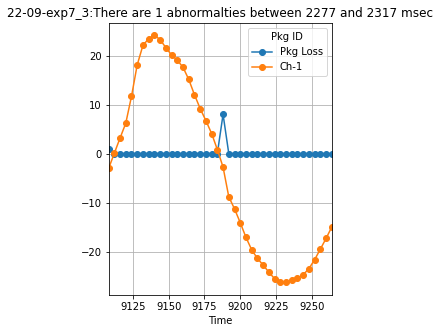

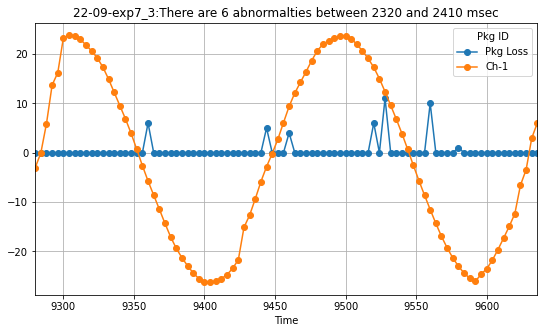

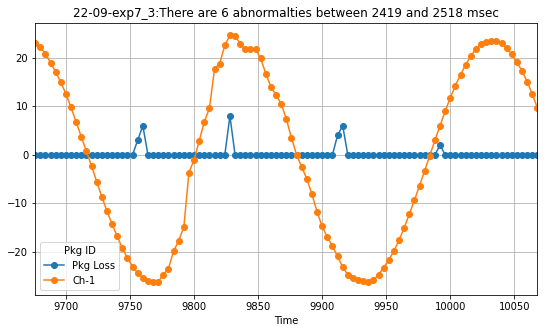

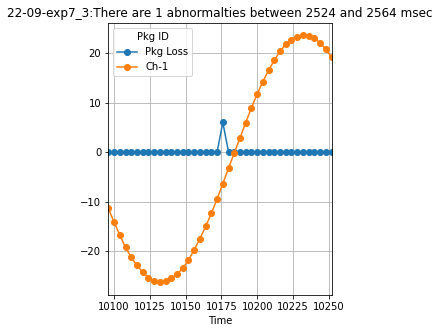

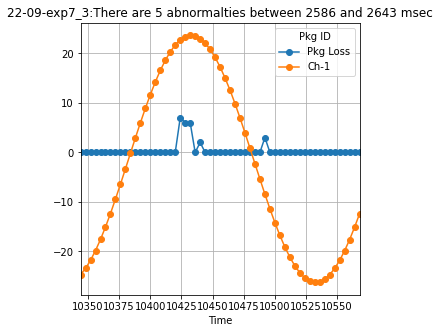

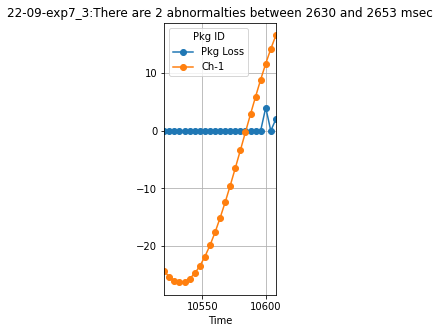

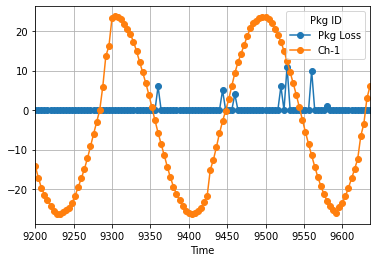

In [110]:
def PlotWherePkgLost(justTheFile, save = False):
    name = justTheFile[0:6]+justTheFile[20:-4]
    
    dif_plot = prepareCsvForPkgId(justTheFile, returnjustfile = True).drop(["Ch-2","Ch-3","Ch-4","Ch-5","Ch-6","Ch-7","Ch-8"], axis=1).dropna(axis=1) 

    #dif_plot["Difference"] =dif_plot.diff(axis=0).abs()
    dif_df = dif_plot.drop(["Ch-1"], axis =1)
    
    bigger = dif_df[(dif_df >1).any(1)]
    
    bd_list = bigger.index.tolist()
    #print(dif_df["Pkg Loss"])
    sortedList = sorted(bd_list) # list of the indexed with jumps

    DictOfJumps = dict(enumerate(grouper2(sortedList, closeMeansWithin=100), 1))
    ratio = round( len(bigger.index)/len(dif_plot.index),3)
    total = sum(dif_df["Pkg Loss"])
    print("For ~{}~ and its {} measured data points, {} are abnormal. The ratio is {}. In total {} (~ {}) packages are lost.\n The losses occur in {} parts of the signal. ".format(justTheFile,len(dif_plot.index),len(bigger.index),ratio,total, total/3, len(DictOfJumps)))
    
    
    for key, value in DictOfJumps.items():

        first_jump = value[0]
        first_jump_pos = int(first_jump/4)
        last_jump = value[-1]
        last_jump_pos = int(last_jump/4)
        plot_from = first_jump_pos -20
        if plot_from < 0:
            plot_from = 0
        plot_to = last_jump_pos +20
        if plot_to > len(dif_plot.index):
            plot_to = len(dif_plot.index)
        rangePlot = plot_to - plot_from
        adaptsize = int(rangePlot/10)
        dif_plot.iloc[plot_from:plot_to].plot(marker ='o', title = "{}:There are {} abnormalties between {} and {} msec".format(name,len(value),plot_from, plot_to), grid=True , figsize = (adaptsize,5))
        if save:
            plt.savefig(name+"_"+str(first_jump)+"_to_"+str(last_jump)+'_msec.png')
    dif_plot.iloc[2300:2410].plot(marker ='o',grid=True)# title = "{}:There are {} abnormalties between {} and {} msec".format(name,len(value),plot_from, plot_to), grid=True , figsize = (adaptsize,5))
    plt.savefig("BadSignalNoApparentPackagelosses.png")
PlotWherePkgLost("22-09-2020_17-05-04_exp7_3.csv")